In [1]:
from cospar import reader, F, paramkeys, datakeys
datakeys = tuple(filter(lambda k: k not in {'t', 'dt'}, datakeys))

import math
import operator
import numpy as np
from functools import reduce
from everest import window
from everest.analysis import time_fourier
from everest.window.data import Data
from matplotlib.pyplot import get_cmap
%matplotlib inline

In [2]:
cut = reader[reduce(operator.__and__, (
    F('f') == 1,
    F('aspect') == 1,
    F('temperatureField') == '_built_peaskauslu-thoesfthuec',
    ))]
tauRefs = reader[cut : 'tauRef']
datas, ts = reader[cut : datakeys], reader[cut : 't']
datasets = [
    (tauRef, ts[k], dict(zip(datakeys, datas[k])))
        for k, tauRef in tauRefs.items()
    ]
datasets.sort()

In [28]:
ffts = []
for tauRef, t, data in datasets:
    Nu = data['Nu']
    mask = t > (max(t) - max(t) * 2 ** -1.5)
    t, Nu = t[mask], Nu[mask]
    freqs, trans = time_fourier(
        t,
        Nu,
        sampleFactor = 10,
        interpKind = 'quadratic',
        minFreq = 1,
        maxFreq = 50.,
#         minAmps = (2,),
        )
    ffts.append((tauRef, freqs, trans))

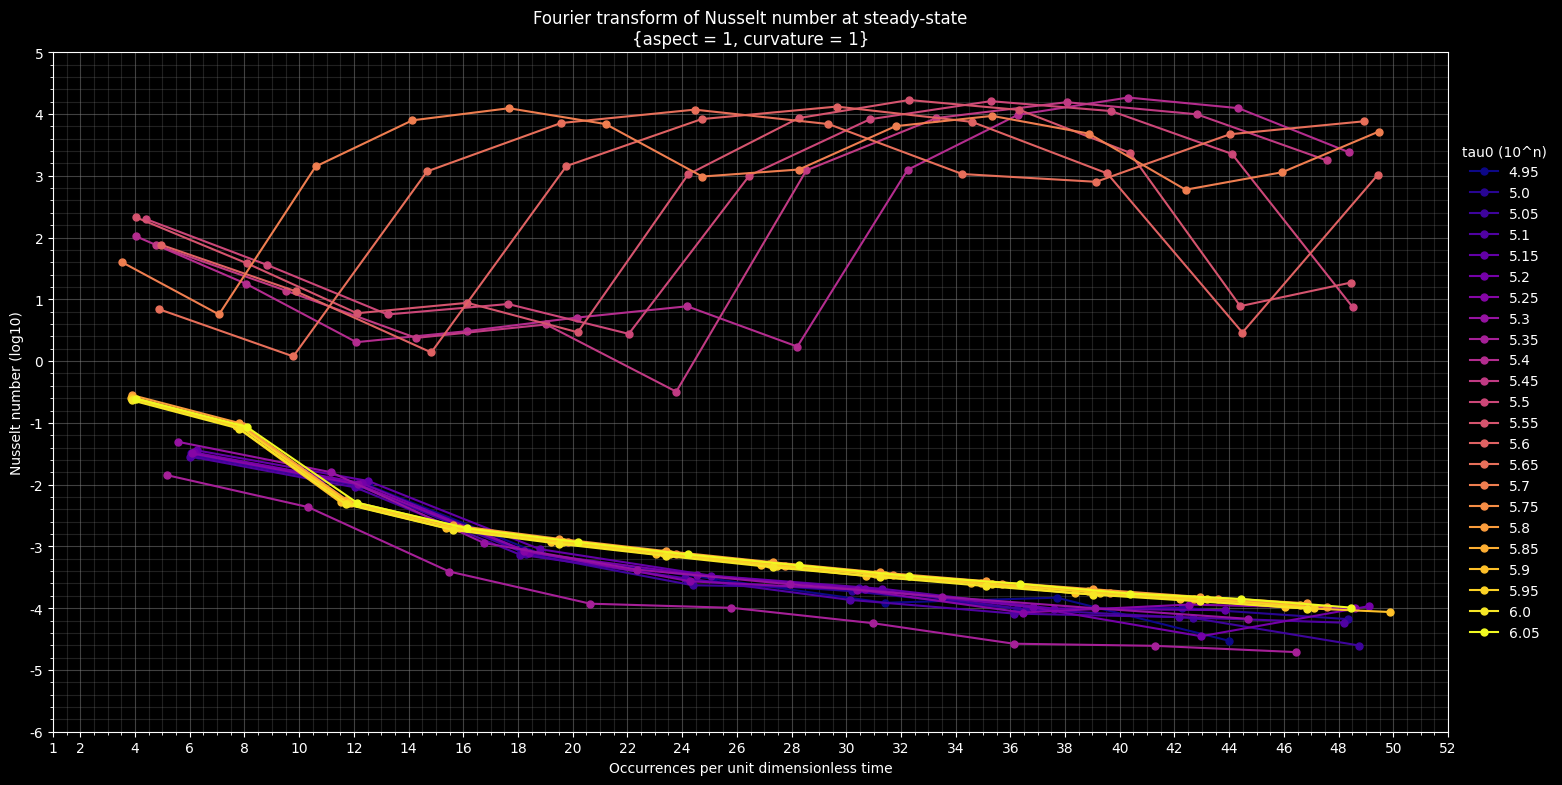

In [32]:
canvas = window.Canvas(size = (18, 9), facecolour = 'black')
ax = canvas.make_ax()
logTaus = [math.log10(tau) for tau in sorted(r[0] for r in datasets)]
normTau = lambda tau: (math.log10(tau) - min(logTaus)) / (max(logTaus) - min(logTaus))
# normTau = lambda tau: (math.log10(tau) - 5.4) / 0.3
cmap = get_cmap('plasma')
for tauRef, freqs, trans in ffts:
    assert np.ptp(freqs) > 0 and np.ptp(trans) > 0, (np.ptp(freqs), np.ptp(trans))
#     if tauRef < 10 ** 5.4: continue
#     if tauRef > 10 ** 5.7: continue
#     if tauRef != 10 ** 5.55: continue
    ax.line(
        Data(freqs, label = 'Occurrences per unit dimensionless time', lims = (1, None), capped = (True, False)),
        Data(np.log10(trans), label = 'Nusselt number (log10)'),
        c = cmap(normTau(tauRef)),
#         linewidth = 1.0,
        marker = 'o',
        markersize = 5,
        )

ax.axes.colour = 'white'
ax.ticks.colour = 'white'
ax.grid.colour = 'grey'
ax.axes.title = 'Fourier transform of Nusselt number at steady-state\n{aspect = 1, curvature = 1}'

legendValues = logTaus
legendHandles = [r[0] for r in ax.collections]
legendLabels = [str(v) for v in legendValues]
handles, labels, _ = zip(*sorted(zip(legendHandles, legendLabels, legendValues), key = lambda r: r[-1]))
legend = ax.ax.legend(
    handles,
    labels,
    loc = 'right',
    framealpha = 0.,
    labelcolor = 'white',
    title = 'tau0 (10^n)',
    bbox_to_anchor = (1.08, 0.5),
    )
legend.properties()['title'].set_color('white')

canvas.show()

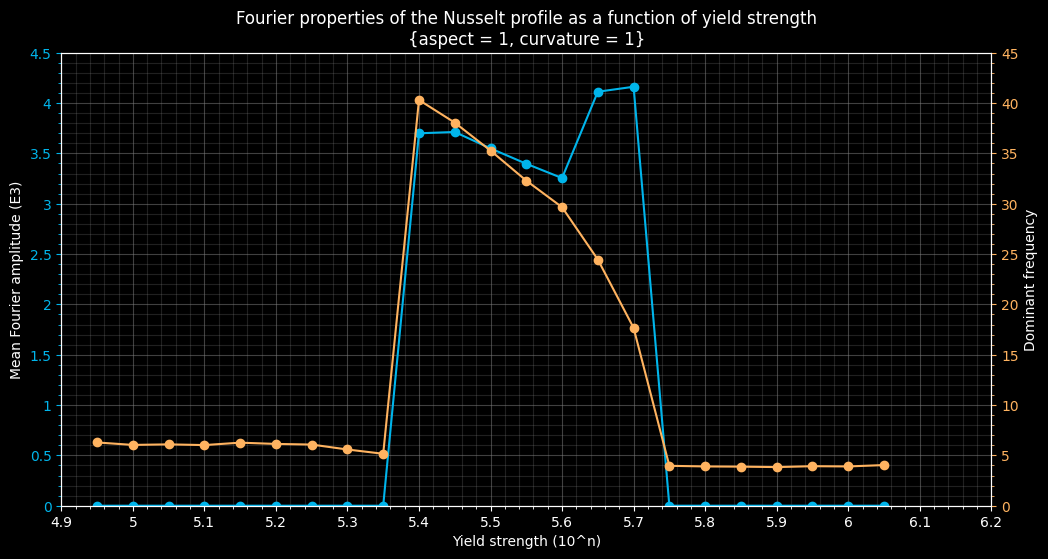

In [33]:
x, y1, y2 = [], [], []
for tauRef, freqs, trans in ffts:
    x.append(math.log10(tauRef))
    y1.append(np.mean(trans))
    y2.append(freqs[list(trans).index(np.max(trans))])
canvas = window.Canvas(size = (12, 6), facecolour = 'black')
ax1 = canvas.make_ax()
ax2 = canvas.make_ax()
ax1.line(
    Data(x, label = 'Yield strength (10^n)'),
    Data(y1, label = 'Mean Fourier amplitude'),
    c = get_cmap('rainbow')(0.25),
    marker = 'o',
    )
ax2.line(
    Data(x, label = 'Yield strength (10^n)'),
    Data(y2, label = 'Dominant frequency'),
    c = get_cmap('rainbow')(0.75),
    marker = 'o',
    )

ax1.axes.colour = ax2.axes.colour = 'white'
ax1.ticks.x.colour = ax2.ticks.x.colour = 'white'
ax1.ticks.y.colour = get_cmap('rainbow')(0.25)
ax2.ticks.y.colour = get_cmap('rainbow')(0.75)
ax2.axes.y.swap()
ax1.grid.colour = ax2.grid.colour = 'grey'
ax2.grid.visible = False
ax2.axes.x.visible = False
ax1.axes.title = 'Fourier properties of the Nusselt profile as a function of yield strength\n{aspect = 1, curvature = 1}'

canvas.show()